<br/><br/><br/><br/><br/>
<div style="text-align:center"><span style="font-weight: bold; font-size:2.5em; line-height: 1.5em;"> Born-again Tree Ensembles</span></div>
<br/><br/>

This Jupyter notebook contains a working example for the whole tool chain used in the paper Born-again tree ensembles, presented at the 37<sup>th</sup> International Conference of Machine Learning (ICML 2020).

To avoid compiler and package conflicts, we recommend to consult the instructions of the README file before running this notebook.

The notebook illustrates the following steps:

1. Parameter specification
2. Data input
3. Import of the Random Forest
4. Dynamic programming algorithm compilation (C++ code)
5. Dynamic programming algorithm execution
6. Display of the original Random Forest
7. Display of the pruned optimal Born-Again Tree
8. Classification performance evaluation

In [1]:
import os
import sys
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.display import display
from sklearn.metrics import classification_report
source_path = os.path.abspath('../src')
output_path = os.path.abspath('../output')
sys.path.append(source_path)
import datasets as ds
import random_forests as rf
import persistence as tree_io
import visualization as tree_view

## 1. Parameter specification

In [2]:
selected_n_obj = rf.create_objective_selection()
selected_n_tree = rf.create_n_trees_selection()
selected_kfold = ds.create_kfold_selection()
selected_datasets = ds.create_dataset_selection() 
selected_cplex = ds.create_cplex_linking_selection()

Dropdown(description='Objective:', index=3, options=(('Depth', 0), ('NbLeaves', 1), ('Depth > NbLeaves', 2), (…

IntSlider(value=10, continuous_update=False, description='#Trees:', max=10, min=3)

IntSlider(value=1, continuous_update=False, description='Fold:', max=10, min=1)

Select(description='Datasets', options=('Breast-Cancer-Wisconsin', 'COMPAS-ProPublica', 'FICO', 'HTRU2', 'Pima…

Checkbox(value=False, description='CPLEX linking', indent=False)

## 2. Data input

In [3]:
# Loading Parameters...
current_obj = selected_n_obj.value
current_dataset=ds.dataset_names[selected_datasets.index]
current_fold = selected_kfold.value
n_trees = selected_n_tree.value
using_cplex = selected_cplex.value

max_tree_depth = 3
print('Selected parameters:\n')
print('  Fold:', current_fold)
print('  Objective:', selected_n_obj.label)
print('  No. of trees:', n_trees)
print('  Dataset:', current_dataset)
print('  Using CPLEX:', using_cplex)

# Loading data 
df_train, df_test, ds_infos = ds.load(current_dataset, current_fold)
X_train, y_train = df_train.iloc[:,:-1].values, df_train.iloc[:,-1].values
X_test, y_test = df_test.iloc[:,:-1].values, df_test.iloc[:,-1].values

Selected parameters:

  Fold: 1
  Objective: Heuristic
  No. of trees: 10
  Dataset: COMPAS-ProPublica
  Using CPLEX: False


In [4]:

max_tree_depth = 3
print('Selected parameters:\n')
print('  Fold:', current_fold)
print('  Objective:', selected_n_obj.label)
print('  No. of trees:', n_trees)
print('  Dataset:', current_dataset)
print('  Using CPLEX:', using_cplex)

# Loading data 
df_train, df_test, ds_infos = ds.load(current_dataset, current_fold)
X_train, y_train = df_train.iloc[:,:-1].values, df_train.iloc[:,-1].values
X_test, y_test = df_test.iloc[:,:-1].values, df_test.iloc[:,-1].values

Selected parameters:

  Fold: 1
  Objective: Heuristic
  No. of trees: 10
  Dataset: COMPAS-ProPublica
  Using CPLEX: False


## 3. Import of the Random Forest

In [5]:
random_forest, random_forest_file = rf.load(X_train, y_train, current_dataset,
                                            current_fold, n_trees, return_file=True)
rf_trees = [e.tree_ for e in random_forest.estimators_]

## 4. Dynamic programming algorithm compilation (C++ code)

In [6]:
if 0 == os.system('make --directory=../src/born_again_dp {} > buildlog.txt'.format('withCPLEX=1' if using_cplex else '')):
    print('Dynamic Program was successful built.')
else:
    print('Error while compiling the program with the make commend. Please verify that a suitable compiler is available.')
    os.system('make --directory=../src/born_again_dp')

Dynamic Program was successful built.


## 5. Dynamic programming algorithm execution

In [7]:
# Calling executable to compute Born-Again Tree
born_again_file = "{}.BA{}".format(current_dataset, current_fold)
ret = subprocess.run(['../src/born_again_dp/bornAgain',
                random_forest_file,
                born_again_file,
                '-trees', str(n_trees),
                '-obj', str(current_obj)], stdout=subprocess.PIPE)

print("Executed command: \"{}\"\n".format(' '.join(ret.args)))
print(ret.stdout.decode('utf-8'))
if ret.returncode != 0:
    print(ret.stderr.decode('utf-8'))
print('Program exited with code {}.'.format(ret.returncode))

# Visualizing...
born_again = tree_io.classifier_from_file(born_again_file+".tree", X_train, y_train, pruning=False)
born_again_pruned = tree_io.classifier_from_file(born_again_file+".tree", X_train, y_train, pruning=True)

Executed command: "../src/born_again_dp/bornAgain /home/cril/Téléchargements/BA-Trees-master/src/resources/forests/COMPAS-ProPublica/COMPAS-ProPublica.RF1.txt COMPAS-ProPublica.BA1 -trees 10 -obj 4"

----- READING RANDOM FOREST from /home/cril/Téléchargements/BA-Trees-master/src/resources/forests/COMPAS-ProPublica/COMPAS-ProPublica.RF1.txt
READING: [TREE 0]
READING: [TREE 1]
READING: [TREE 2]
READING: [TREE 3]
READING: [TREE 4]
READING: [TREE 5]
READING: [TREE 6]
READING: [TREE 7]
READING: [TREE 8]
READING: [TREE 9]
----- OPTIMAL SOLUTION FOUND                      
----- OBJECTIVE:                                  Heuristic
----- CPU TIME(s):                                0.015607
----- ORIGINAL CELLS:                             139823513932728
----- FILTERED CELLS:                             0
----- NB SUBPROBLEMS:                             1.39824e+14
----- NB RECURSIVE CALLS:                         6.87195e+10
----- BA TREE DEPTH:                              8
----- BA TREE 

## 6. Display of the original Random Forest

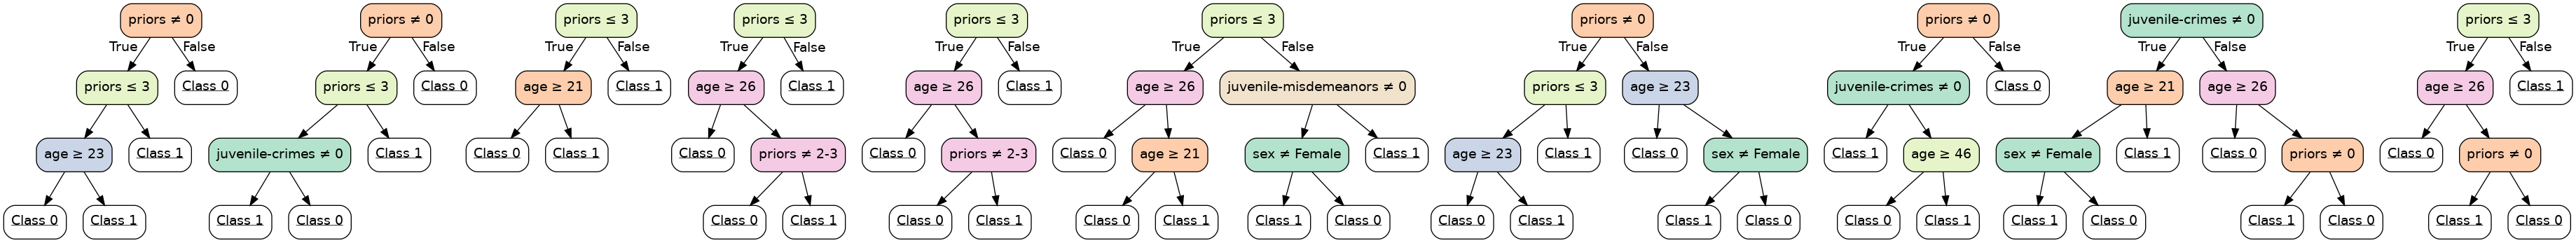

In [8]:
display(Image(tree_view.create_graph(rf_trees, features=ds_infos['features'], classes=ds_infos['classes'], colors=ds_infos['colors']).create_png()))

## 7. Display of the pruned optimal Born-Again Tree

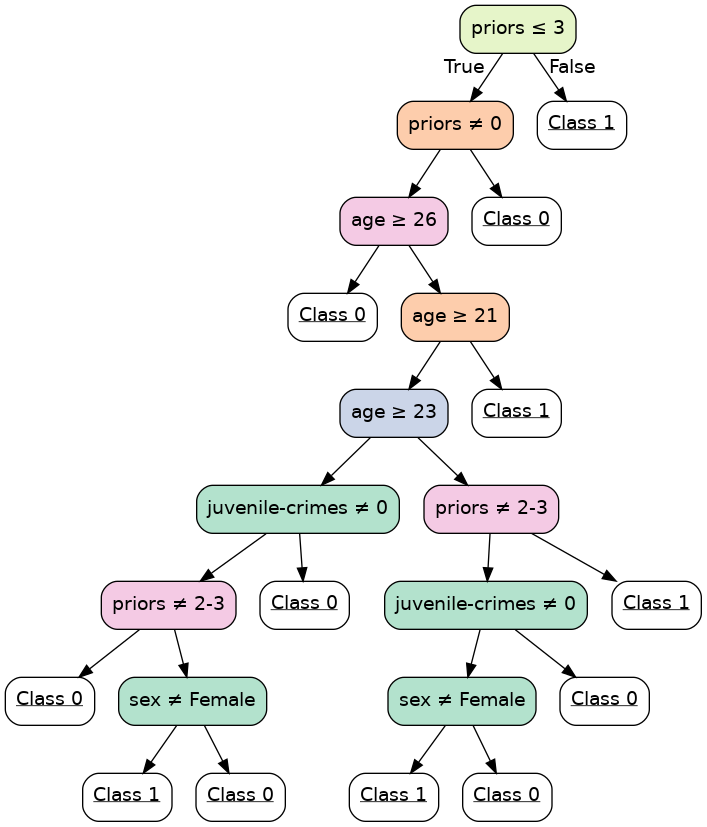

In [11]:
display(Image(tree_view.create_graph([born_again_pruned.tree_], features=ds_infos['features'], classes=ds_infos['classes'], colors=ds_infos['colors']).create_png()))

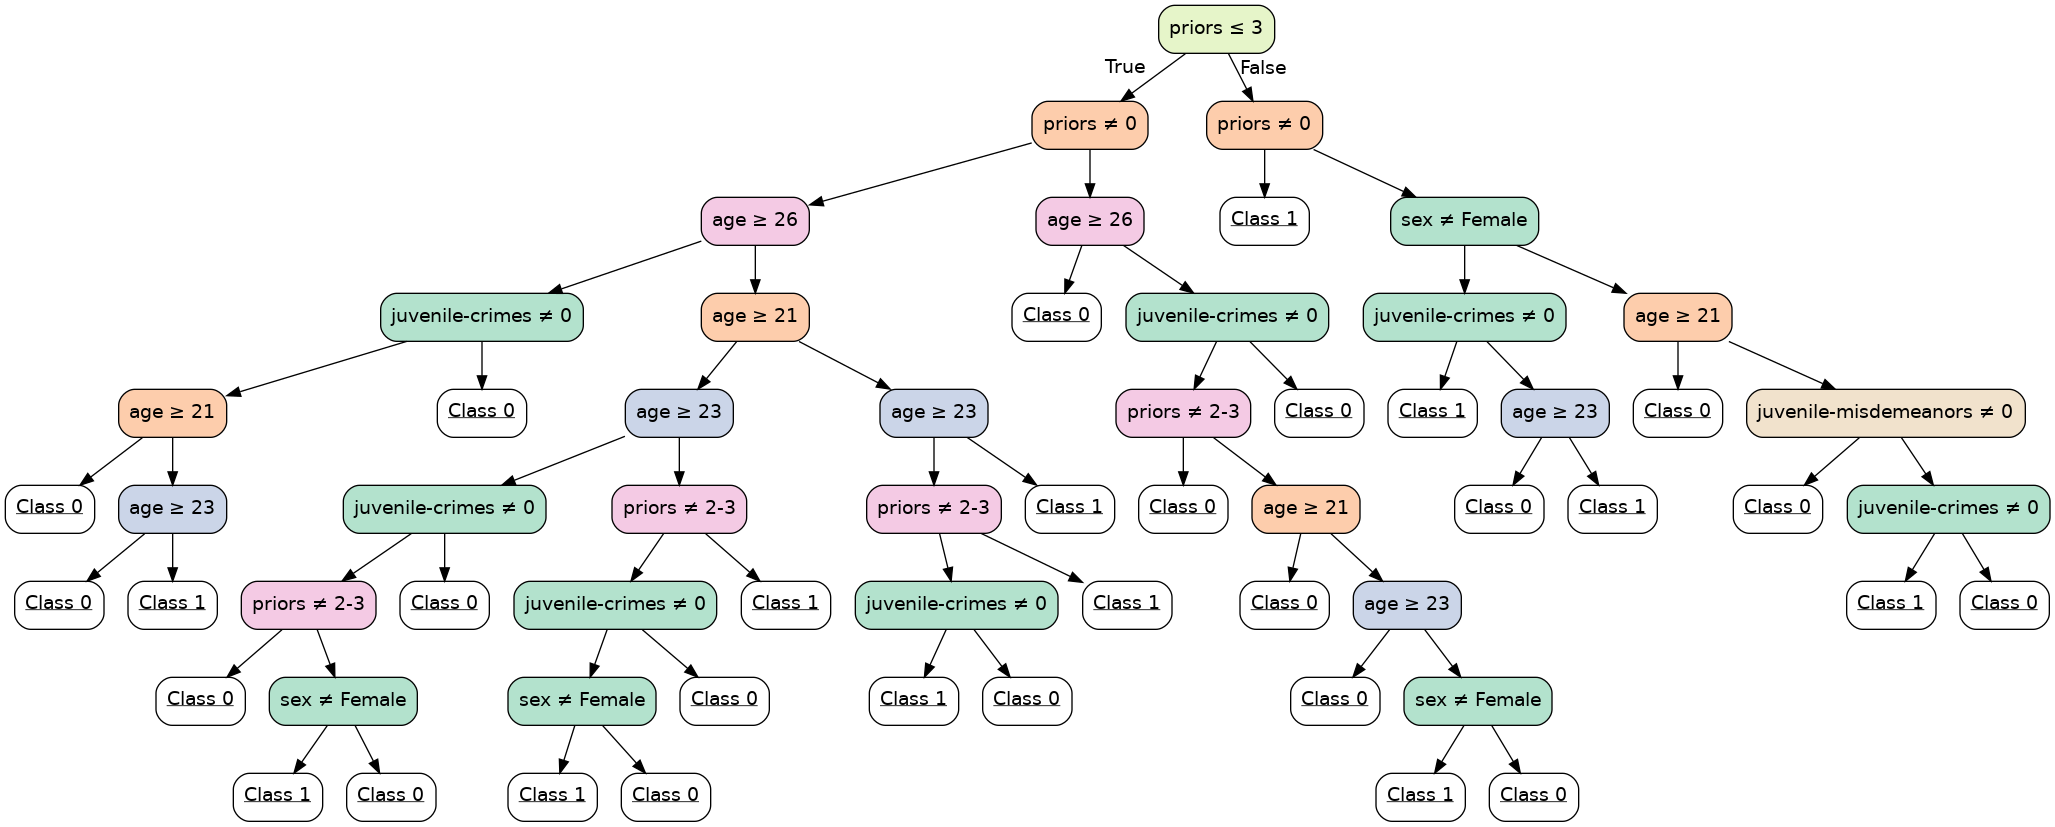

In [12]:
display(Image(tree_view.create_graph([born_again.tree_], features=ds_infos['features'], classes=ds_infos['classes'], colors=ds_infos['colors']).create_png()))

## 8. Classification performance evaluation

In [23]:
#RandomForest
rf_test_pred = random_forest.predict(X_test)
rf_train_pred = random_forest.predict(X_train)
report_rf = classification_report(y_test, rf_test_pred, output_dict=True)
report_rf_train = classification_report(y_train, rf_train_pred, output_dict=True)

#BornAgain
ba_test_pred = born_again.predict(X_test)
ba_train_pred = born_again.predict(X_train)
report_ba = classification_report(y_test, ba_test_pred, output_dict=True)
report_ba_train = classification_report(y_train, ba_train_pred, output_dict=True)

#BornAgain-Pruned
ba_pruned_test_pred = born_again_pruned.predict(X_test)
ba_pruned_train_pred =  born_again_pruned.predict(X_train)
report_ba_pruned = classification_report(y_test, ba_pruned_test_pred, output_dict=True)
report_ba_pruned_train = classification_report(y_train, ba_pruned_train_pred, output_dict=True)

df = {' ': [], 'Train-Acc': [], 'Train-F1': [], 'Test-Acc': [], 'Test-F1': []}
def add_report(df, method, train_stat, test_stat):
    df[' '].append(method)
    df['Train-Acc'].append(train_stat['accuracy'])
    df['Train-F1'].append(train_stat['weighted avg']['f1-score'])
    df['Test-Acc'].append(test_stat['accuracy'])
    df['Test-F1'].append(test_stat['weighted avg']['f1-score'])

add_report(df, 'RandomForest', report_rf_train, report_rf)
add_report(df, 'BornAgain', report_ba_train, report_ba)
add_report(df, 'BornAgain-Pruned', report_ba_pruned_train, report_ba_pruned)

pd.DataFrame(data=df, index=None)

,,Train-Acc,Train-F1,Test-Acc,Test-F1
0,RandomForest,0.657014,0.655006,0.662808,0.661728
1,BornAgain,0.657014,0.655006,0.662808,0.661728
2,BornAgain-Pruned,0.657014,0.655006,0.662808,0.661728
